In [1]:
import numpy as np
import h5py
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from helpers import *
from scipy.interpolate import pchip
style_dict = styleTracks()

(0.725, 0.73)

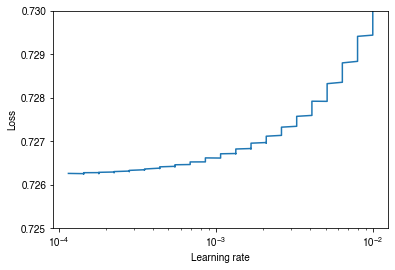

In [8]:
#f = h5py.File('../default_results-rej_per_eff-280.h5', 'r')
#list(f.keys())
#df = pd.read_hdf('Umami_backups/nom/results/results-rej_per_eff-173.h5','ttbar')
df = pd.read_json('Umami_backups/nom/DictFile2.json')
df

plt.plot(df['lr'], df['loss'])
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.ylim(0.725, 0.730)

In [2]:
class NNPlots:
    def __init__(self, models, epochs, sample='ttbar', in_dir='umami_results', out_dir='NN_', xmin=0.4):
        self.models = models
        self.baseline_model = models[0]
        self.epochs = epochs
        self.sample = sample
        self.in_dir = in_dir
        self.out_dir = out_dir
        self.xmin = xmin
        
        self.model_styles = {
            'nom': ["#000000", "Default"],
            'nom-leaky': ["#1f77b4", "Leaky ReLU"],
            'nom-CLR': ["#7373c6", "Triangular"],
            'nom-expCLR': ["#f25396", "Exponential range"],  
        }
    
    def get_rej_values(self):
        roc_values_dict = {}
        for i, model in enumerate(self.models):
            df = pd.read_hdf(f'{self.in_dir}/{model}/results-rej_per_eff-{str(self.epochs[i])}.h5', self.sample)
            for jet in ['c', 'u']:
                roc_values_dict[model + '_' + jet + 'rej'] = df['umami_{}rej'.format(jet)]
            if model == 'nom':
                roc_values_dict["beff"] = df["beff"]
        
        return roc_values_dict
    
    
    def configure_plot(self, jet, width=600, height=400, label_size=12, my_dpi=100):
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['xtick.labelsize'] = label_size 
        plt.rcParams['ytick.labelsize'] = label_size 
        plt.rcParams['axes.labelsize'] = label_size 
        fig = plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
        gs = gridspec.GridSpec(8, 1, figure=fig)
        ax1 = fig.add_subplot(gs[:5, 0])
        ax2 = fig.add_subplot(gs[5:, 0], sharex=ax1)
        
        ax2.set_xlabel('$b$-efficiency', horizontalalignment='right', x=1.0)
        if jet == "c":
            ax1.set_ylabel('$c$-jet rejection',  horizontalalignment='right', y=1.0)
        if jet == "u":
            ax1.set_ylabel('light-jet rejection', horizontalalignment='right', y=1.0)
        ax1.set_yscale('log')
        ax2.set_ylabel('Ratio')
        ax2.grid()
        ax1.grid()
        plt.setp(ax1.get_xticklabels(), visible=False)
        
        if self.text is not None:
            ax1.text(**self.text, transform=ax1.transAxes)
        
        # Set the axes to be the same as those used in the pub note
        ax1.set_xlim(self.xmin, 1)
        ax2.set_xlim(self.xmin, 1)
        if jet == "c": ax1.set_ylim(1, 1e3)
        if jet == "u": ax1.set_ylim(1, 1e5)

        return ax1, ax2
    
    
    def plot_ROCs(self, roc_values_dict, leg_size=12):
        roc_values_dict = self.get_rej_values()
        x = roc_values_dict["beff"]
        x2 = np.linspace(self.xmin, 1, 101)
        
        for jet in ['c', 'u']:
            figname += 'ROC_' + jet + 'rej'
            ax1, ax2 = self.configure_plot(jet)
            
            for model in self.models:
                y = roc_values_dict[model + '_' + jet + 'rej']
                ax1.plot(x, y, color=self.model_styles[model][0], label=self.model_styles[model][1])

                # Approximate function using x and y -> interpolate x2 values using f
                f = pchip(x, y)
                if model == 'default': #'nom'
                    f0 = f
                    ratio = np.ones(len(x2))
                else:
                    ratio = f(x2)/f0(x2)
                
                ax2.plot(x2, ratio, linewidth=1.5, color=self.model_styles[model][0]) 
            ax1.legend(loc='best', fontsize=leg_size)
            plt.savefig(self.out_dir + figname + ".pdf", bbox_inches='tight', pad_inches=0.04)
                    

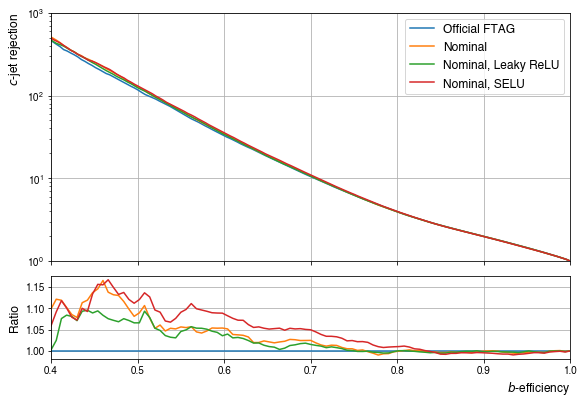

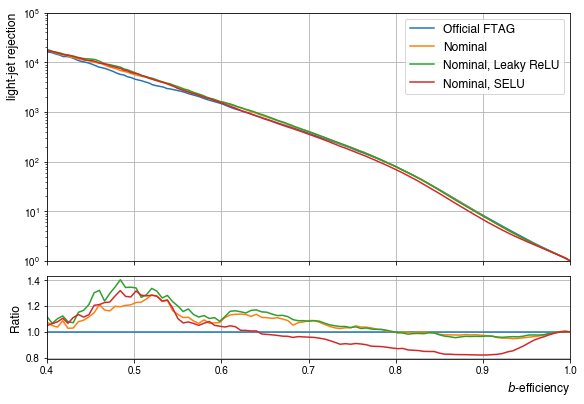

In [3]:
NNPlots(['nom', 'nom-leaky'], [77, 77]).plot_ROCs()